In [16]:
import random
import math
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def create_defense():
    x = random.uniform(-0.45, 0.45)
    y = random.uniform(-0.45, 0.45)
    defense = np.array([x, y])

    return defense

def create_attack(defense):
    x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
    x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
    y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
    y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
    x_inclusive = random.uniform(-0.95, 0.95)
    y_inclusive = random.uniform(-0.95, 0.95)
    y_below_x_inclusive = np.array([x_inclusive, y_below])
    y_above_x_inclusive = np.array([x_inclusive, y_above])
    x_left_y_inclusive = np.array([x_side_left, y_inclusive])
    x_right_y_inclusive = np.array([x_side_right, y_inclusive])

    attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])
    return attack 

def calc_angle(defense, attack):

    # create an adjacent point of the form (attack_x, defense_y)
    adjacent_point = np.array([attack[0], defense[1]])

    # calculate the distance between the adjacent point and the defense, attack points
    adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
    adj_point_attack_len = abs(attack[1] - adjacent_point[1])

    # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
    theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
    
    if attack[0] > defense[0]:
        if attack[1] > defense[1]:
            theta = theta # 1st quadrant
        else: 
            theta = (2*math.pi) - theta # 360 - theta
    else:
        if attack[1] > defense[1]:
            theta = math.pi - theta # 180 - theta
        else:
            theta = math.pi + theta # 180 + theta
        
    return theta

def generate_data(num_samples):
    data = []
    labels = []
    for _ in range(num_samples):
        defense = create_defense()
        attack = create_attack(defense)
        
        # Use your existing calc_angle function
        theta = calc_angle(defense, attack)
        
        data.append(np.concatenate([defense, attack]))
        labels.append(theta)
    
    return np.array(data), np.array(labels)

# Generate data
X, y = generate_data(num_samples=500000)

# Split the original dataset into a training set and a remaining set (80% train, 20% remaining)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining data into validation and test sets (50% validation, 50% test of the remaining data)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Pass this callback to the 'fit' method
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
 2242/12500 [====>.........................] - ETA: 10s - loss: 0.5243 - mae: 0.3455

KeyboardInterrupt: 

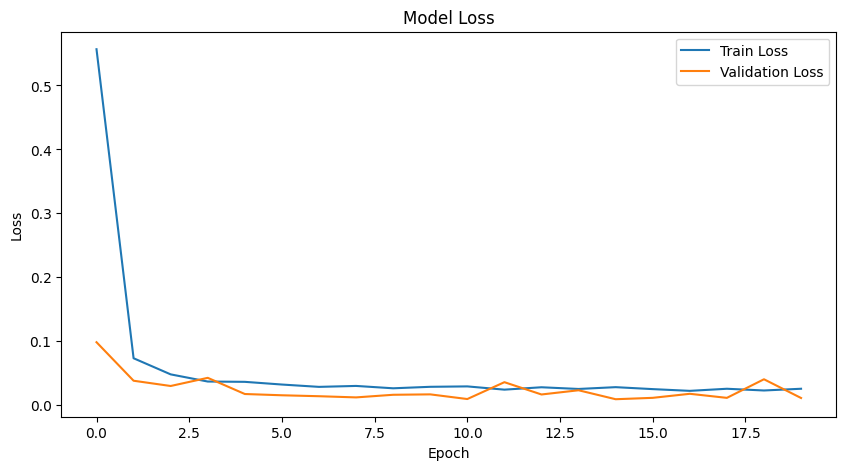

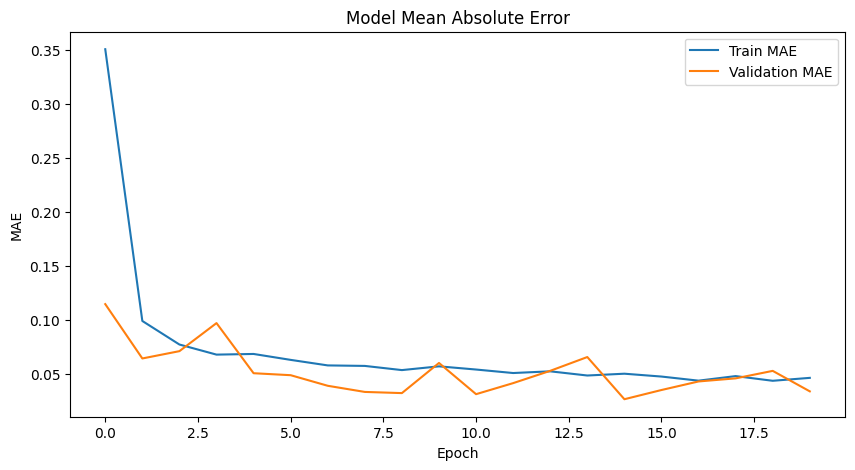

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

313/313 [==============================] - 1s 915us/step - loss: 0.0138 - mae: 0.0285
Test Loss: 0.013808135874569416
Test MAE: 0.02847956493496895


In [ ]:
model.save("defense_attack_angle_model.h5")

In [ ]:
predictions = model.predict(X_test)

for i in range(10):  # Display first 10 predictions
    print(f"True angle: {y_test[i]:.4f}, Predicted angle: {predictions[i][0]:.4f}")

313/313 [==============================] - 2s 772us/step
True angle: 2.6763, Predicted angle: 2.6866
True angle: 4.4071, Predicted angle: 4.4442
True angle: 0.6889, Predicted angle: 0.6562
True angle: 2.3758, Predicted angle: 2.3900
True angle: 4.8909, Predicted angle: 4.8743
True angle: 4.0363, Predicted angle: 4.0339
True angle: 1.0151, Predicted angle: 1.0267
True angle: 4.1886, Predicted angle: 4.1484
True angle: 2.2277, Predicted angle: 2.2095
True angle: 2.7500, Predicted angle: 2.7597
